In [1]:
from pathlib import Path

import minisom
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import shapely
from ipywidgets import interact, widgets
from plotly.colors import sample_colorscale
from plotly.figure_factory import create_dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram
from IPython.display import IFrame, Image

In [2]:
# Parameters
data_path = Path(r'for_Vegard\Piper_Gibbs_Gaillardet_d-grams\1_by_data_Pervomaysk\data_template_Pervomaysk_4.csv')
input_columns = ["pH", "Na"]

prognostic_sample = "sample22"
prognostic_column = "Sample"

som_sigma = 1.5
som_learning_rate = 0.7
som_activation_distance = 'euclidean'
som_topology = 'hexagonal'
som_neighborhood_function = 'gaussian'
som_random_seed = 10
som_max_iterations = 3000

# Visualization
pio.templates.default = 'plotly_white'
plotly_interactive = False

In [3]:
fig_count = 0

def show_figure(fig: go.Figure):
    global fig_count
    if plotly_interactive:
        return fig
    else:
        fn = f'figure_{fig_count}.png'
        fig.write_image(fn, format='png', scale=2)
        fig_count += 1
        return Image(filename=fn)
        

In [4]:
# Read input data
df = pd.read_csv(data_path)
df

,Sample,Label,Color,Marker,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS
0,sample1,K-1,red,o,0.6,30,7.5,3.2,7.1,11.5,1.3,14.8,0,2.2,3.5,1483
1,sample2,K-1,red,o,0.6,30,7.7,2.6,7.0,13.0,1.4,13.3,0,3.8,3.2,1601
2,sample3,K-1,red,o,0.6,30,7.3,1.2,8.0,12.0,1.3,13.9,0,2.0,3.4,1542
3,sample4,K-1,red,o,0.6,30,7.4,2.2,6.6,12.6,1.4,13.6,0,2.4,3.1,1518
4,sample5,K-1,red,o,0.6,30,7.3,2.5,9.6,10.3,1.1,14.3,0,2.0,3.4,1476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,sample98,P-7,orange,o,0.6,30,7.9,1.8,2.4,3.8,0.4,4.0,0,1.0,3.4,856
98,sample99,P-8,cyan,o,0.6,30,7.5,12.2,14.0,8.6,1.0,5.5,0,6.0,23.4,2394
99,sample100,P-8,cyan,o,0.6,30,7.8,12.8,13.4,9.6,1.1,6.3,0,6.0,23.8,2456
100,sample101,P-8,cyan,o,0.6,30,7.8,11.6,12.0,11.4,1.3,5.2,0,6.2,23.8,2435


In [5]:
# Derive SOM dimensions
som_m = 5 * np.sqrt(len(df))
som_nx = np.round(np.sqrt(som_m)).astype(int)
som_ny = np.round(som_m / som_nx).astype(int)

print(f"SOM dimensions: {som_nx} x {som_ny}")

SOM dimensions: 7 x 7


In [6]:
# Split data set into test and training based on prognostic sample
predict = df[prognostic_column] == prognostic_sample

test_df = df[predict]
train_df = df[~predict]
if test_df.size == 0:
    print("Failed to determine prognostic_sample")
test_df

,Sample,Label,Color,Marker,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS
21,sample22,K-6,magenta,o,0.6,30,7.8,6.1,7.6,15.8,1.8,14.8,0,6.4,9.1,2185


In [7]:
# Alternative approach if we want to extend to draw prognostic sample randomly, e.g. for cross-validation
# import sklearn.model_selection
# train_df, test_df = sklearn.model_selection.train_test_split(df, test_size=1, random_state=200)

In [8]:
# Train the SOM model

# Set up data transform for input
input_array = train_df[input_columns].values
norm_b = input_array.min(axis=0)
norm_a = input_array.max(axis=0) - norm_b
data_transform = lambda x: (x - norm_b) / norm_a
inverse_data_transform = lambda y: norm_a * y + norm_b

# Set up model
som = minisom.MiniSom(
    som_nx,
    som_ny,
    len(input_columns),
    sigma=som_sigma,
    learning_rate=som_learning_rate,
    activation_distance=som_activation_distance,
    topology=som_topology,
    neighborhood_function=som_neighborhood_function,
    random_seed=som_random_seed,
)

# Train
som.train(data_transform(input_array), som_max_iterations)

# Extract data
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()
test_wm = som.win_map(data_transform(test_df[input_columns].values), return_indices=True)
train_wm = som.win_map(data_transform(train_df[input_columns].values), return_indices=True)

In [9]:
# Create hexagons for visualization
def hexagon(_xx, _yy, radius):
    # Returns a NX x NY x 6 x 2 array of hexagon coordinates
    hex_xy = np.zeros((_xx.shape[0], _xx.shape[1], 7, 2))
    for i in range(7):
        theta = np.pi / 6 + 2 * np.pi * i / 6
        hex_xy[:, :, i, 0] = _xx + radius * np.cos(theta)
        hex_xy[:, :, i, 1] = _yy + radius * np.sin(theta)
    return hex_xy


hexagons = hexagon(xx, yy, 0.4)
hexagons.shape

(7, 7, 7, 2)

In [10]:
# Setup input to clustering and dendrogram plot
mij = np.meshgrid(np.arange(som_nx), np.arange(som_ny), indexing='ij')
cells_ij = np.column_stack((mij[0].flat, mij[1].flat))
labels = [f'{i}-{j}' for i, j in cells_ij]
flat_weights = weights.reshape(-1, 2) 

links = linkage(flat_weights, method='complete', metric='euclidean')

In [11]:
# Create cluster boundaries
cluster_hexagons = {
    lab: h for lab, h in 
    zip(labels, hexagon(xx, yy, np.sqrt(3) / 3 + 0.001).reshape(-1, 7, 2))
}

z = dendrogram(links, no_plot=True, get_leaves=True, labels=labels)

cluster_boundaries = {}
for c in set(z['leaves_color_list']):
    matches = np.array(z['leaves_color_list']) == c
    
    matching_polys = []
    for leaf_color, leaf_label in zip(z['leaves_color_list'], z['ivl']):
        if leaf_color == c:
            matching_polys.append(cluster_hexagons[leaf_label])
    
    cluster_boundaries[c] = shapely.union_all([shapely.Polygon(p) for p in matching_polys])

    
    # p = cluster_hexagons[np.array(z['leaves_color_list']) == c]
    # cluster_boundaries[c] = p
    # cluster_boundaries[c] = [shapely.Polygon(p) for p in p]

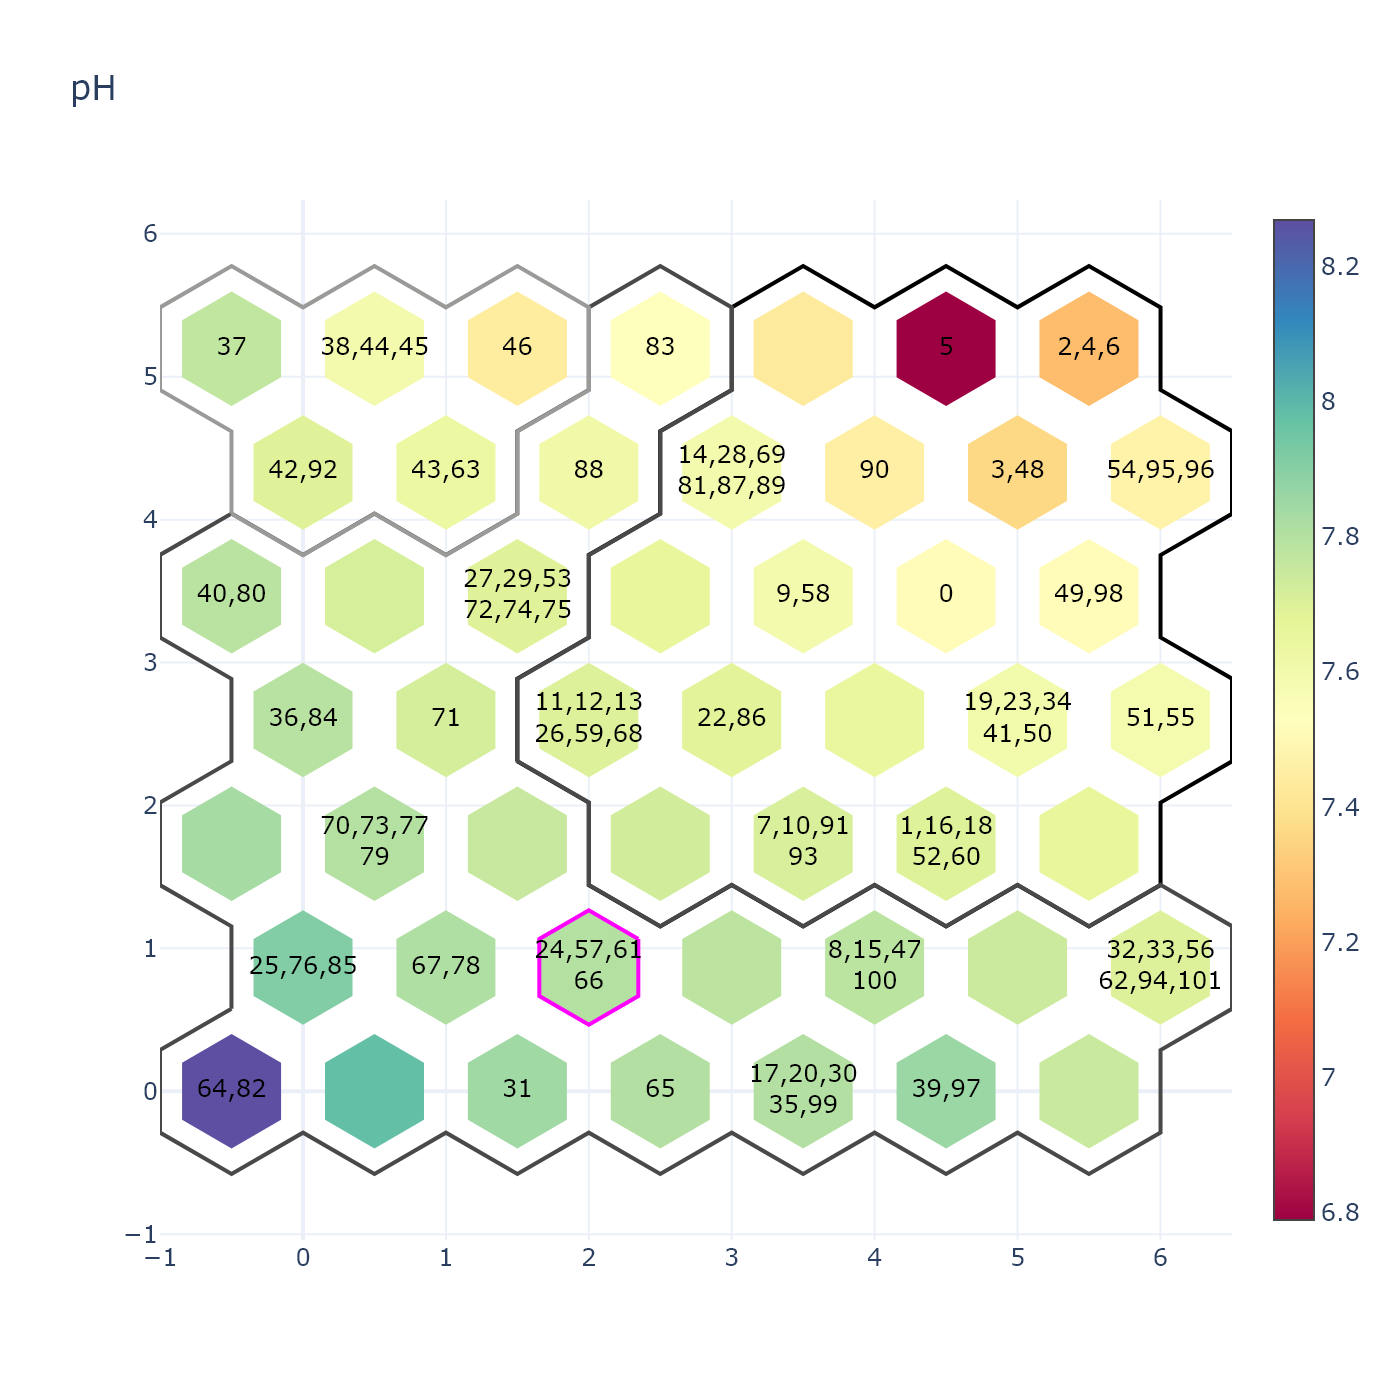

In [12]:
# Define function for plotting and invoke for interactive visualization

def generate_plot(feature_index):
    if feature_index >= weights.shape[2]:
        w = umatrix.copy()
    else:
        w = inverse_data_transform(weights)[:, :, feature_index]

    w_min = w.min()
    w_max = w.max()

    w -= w.min()
    w /= w.max()
    col = np.array(sample_colorscale('spectral', w.flatten())).reshape(som_nx, som_ny)
    
    # Start plot creation
    fig = go.Figure()
    
    # Add cluster boundaries
    n_boundaries = len(cluster_boundaries)
    for i, (k, boundary) in enumerate(cluster_boundaries.items()):
        clr = sample_colorscale('gray', i / n_boundaries)[0]
        
        if boundary.geom_type == 'Polygon':
            bnds = [boundary]
        elif boundary.geom_type == 'MultiPolygon':
            bnds = list(boundary.geoms)
        else:
            raise NotImplementedError(boundary.geom_type)
        
        for poly in bnds:
            if poly.boundary.geom_type == 'LineString':
                crds = np.array(poly.boundary.coords)
            else:
                crds = np.array(poly.boundary.geoms[0].coords)
            
            fig.add_scatter(
                x=crds[:, 0],
                y=crds[:, 1],
                # fill='toself',
                mode="lines",
                showlegend=False,
                line=dict(color=clr, width=2),
            )
    
    # Add colored hexagons
    for i in range(som_nx):
        for j in range(som_ny):
            text = ""
            if len(train_wm[(i, j)]) > 0:
                samples = [str(s) for s in sorted(train_df.iloc[train_wm[(i, j)]].index.values.tolist())]
                if len(samples) <= 3:
                    text = f"{','.join(samples)}"
                elif len(samples) <= 6:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:])}"
                elif len(samples) <= 9:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:6])}" + f"<br>{','.join(samples[6:])}"
                else:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:-3])}" + f"<br>{','.join(samples[-3:])}"
                    
                
            is_winning = len(test_wm[(i, j)]) > 0
                
            fig.add_scatter(
                x=hexagons[i, j, :, 0],
                y=hexagons[i, j, :, 1],
                fill='toself',
                mode='lines',
                fillcolor=col[i, j],
                line=dict(color='magenta', width=2) if is_winning else dict(color='black', width=0),
                text=text,
                showlegend=False,
                hoverinfo="text",
                hoveron="fills",
            )
            
            mid = (hexagons[i, j, 0, :] + hexagons[i, j, 3, :]) / 2
            fig.add_scatter(
                x=[mid[0]],
                y=[mid[1]],
                mode="text",
                # text=f"{len(train_wm[(i, j)])}" if len(train_wm[(i, j)]) > 0 else "",
                text=text,
                textfont=dict(color="black"),
                marker=dict(color='black'),
                showlegend=False,
                hoverinfo="none",
            )
           
    fig.add_scatter(
        x=[0, 0],
        y=[0, 0],
        showlegend=False,
        marker=dict(color=[w_min, w_max], colorscale="spectral", size=0.001, colorbar=dict(thickness=20)),
    )
            
    fig.layout.title.text = input_columns[feature_index] if feature_index < weights.shape[2] else "Umatrix"
    fig.layout.yaxis.scaleanchor = 'x'
    fig.layout.height = 700
            
    return fig

# For interactive experimentation:
# interact(generate_plot, feature_index=widgets.IntSlider(min=0, max=len(input_columns) - 1 + 1, step=1, value=0))
fig = generate_plot(0)
show_figure(fig)

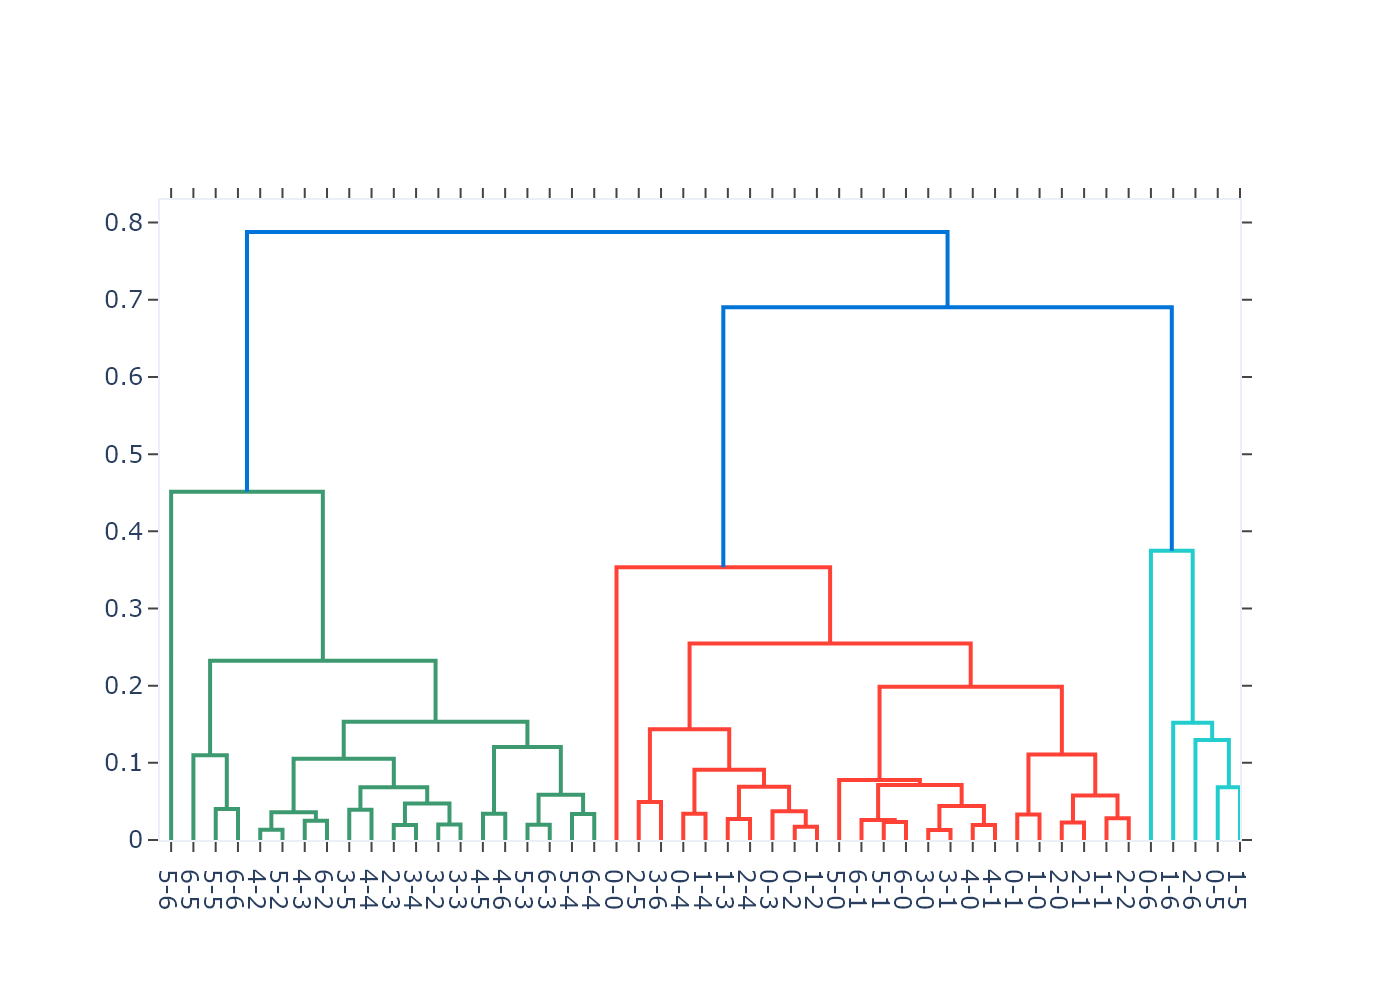

In [13]:
# Using method 'complete' in scipy's linkage function yields the same as the default in create_dendrogram
show_figure(create_dendrogram(flat_weights, linkagefun=lambda _: links, labels=labels))

## Winning cell (SOM)

In [14]:
winning_cell = [ij for ij, mtc in test_wm.items() if len(mtc) > 0][0]
print(f"Winning cell: {winning_cell}")
matching_cells = train_wm[winning_cell]
print(f"Matching cells: {matching_cells}")
pd.concat((test_df.iloc[[0]], train_df.iloc[matching_cells]))

Winning cell: (2, 1)
Matching cells: [23, 56, 60, 65]


,Sample,Label,Color,Marker,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS
21,sample22,K-6,magenta,o,0.6,30,7.8,6.1,7.6,15.8,1.8,14.8,0,6.4,9.1,2185
24,sample25,K-6,magenta,o,0.6,30,7.8,4.2,8.0,18.0,2.0,13.6,0,6.6,8.5,2172
57,sample58,K-22,tan,o,0.6,30,7.8,5.0,11.0,17.6,2.0,12.2,0,7.8,7.1,2115
61,sample62,K-24,darkblue,o,0.6,30,7.8,15.6,14.8,15.8,1.8,10.0,0,10.0,13.4,2616
66,sample67,K-31,springgreen,o,0.6,30,7.8,8.6,15.0,16.6,1.8,10.8,0,9.8,16.0,2612


## Winning cell (distance)

In [15]:
train_sds = train_df[input_columns].std()
dists = np.linalg.norm((train_df[input_columns] - test_df[input_columns].iloc[0]) / train_sds, axis=1)
closest = np.argsort(dists)
pd.concat((test_df.iloc[[0]], train_df.iloc[closest[:5]]))

,Sample,Label,Color,Marker,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS
21,sample22,K-6,magenta,o,0.6,30,7.8,6.1,7.6,15.8,1.8,14.8,0,6.4,9.1,2185
61,sample62,K-24,darkblue,o,0.6,30,7.8,15.6,14.8,15.8,1.8,10.0,0,10.0,13.4,2616
66,sample67,K-31,springgreen,o,0.6,30,7.8,8.6,15.0,16.6,1.8,10.8,0,9.8,16.0,2612
57,sample58,K-22,tan,o,0.6,30,7.8,5.0,11.0,17.6,2.0,12.2,0,7.8,7.1,2115
65,sample66,K-31,springgreen,o,0.6,30,7.8,10.3,12.3,13.9,1.5,11.5,0,9.4,16.3,2532
24,sample25,K-6,magenta,o,0.6,30,7.8,4.2,8.0,18.0,2.0,13.6,0,6.6,8.5,2172


## Sample

In [16]:
train_df.loc[[36, 40, 80]]

,Sample,Label,Color,Marker,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS
36,sample37,K-11,brown,o,0.6,30,7.8,11.4,1.2,26.6,3.0,9.3,0,7.4,24.2,2941
40,sample41,K-13a,green,o,0.6,30,7.8,12.6,26.8,27.8,3.1,16.2,0,10.4,37.9,4620
80,sample81,P-3,red,o,0.6,30,7.8,1.4,7.6,27.4,3.0,13.8,0,8.0,13.0,2651


In [17]:
train_df.loc[[64, 82]]

,Sample,Label,Color,Marker,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS
64,sample65,K-26,yellowgreen,o,0.6,30,8.3,6.4,21.2,32.2,3.6,8.6,0,20.6,28.7,3922
82,sample83,P-4,green,o,0.6,30,8.4,9.0,13.4,21.2,2.4,14.1,0,13.6,13.5,3015


In [18]:
v = (train_df[input_columns] / train_sds).values
# train_distance_matrix = np.linalg.norm((v - train_df[input_columns].) / train_sds, axis=1)

In [19]:
train_distance_matrix = np.linalg.norm(v.reshape(-1, 2, 1) - v.T, axis=1)

In [20]:
train_distance_matrix

array([[0.        , 0.93942406, 0.93091577, ..., 1.40502933, 1.39479866,
        0.96053076],
       [0.93942406, 0.        , 1.86183153, ..., 0.55509749, 0.48633621,
        0.37464146],
       [0.93091577, 1.86183153, 0.        , ..., 2.33445375, 2.32523291,
        1.88147192],
       ...,
       [1.40502933, 0.55509749, 2.33445375, ..., 0.        , 0.16056062,
        0.47036798],
       [1.39479866, 0.48633621, 2.32523291, ..., 0.16056062, 0.        ,
        0.51955852],
       [0.96053076, 0.37464146, 1.88147192, ..., 0.47036798, 0.51955852,
        0.        ]])

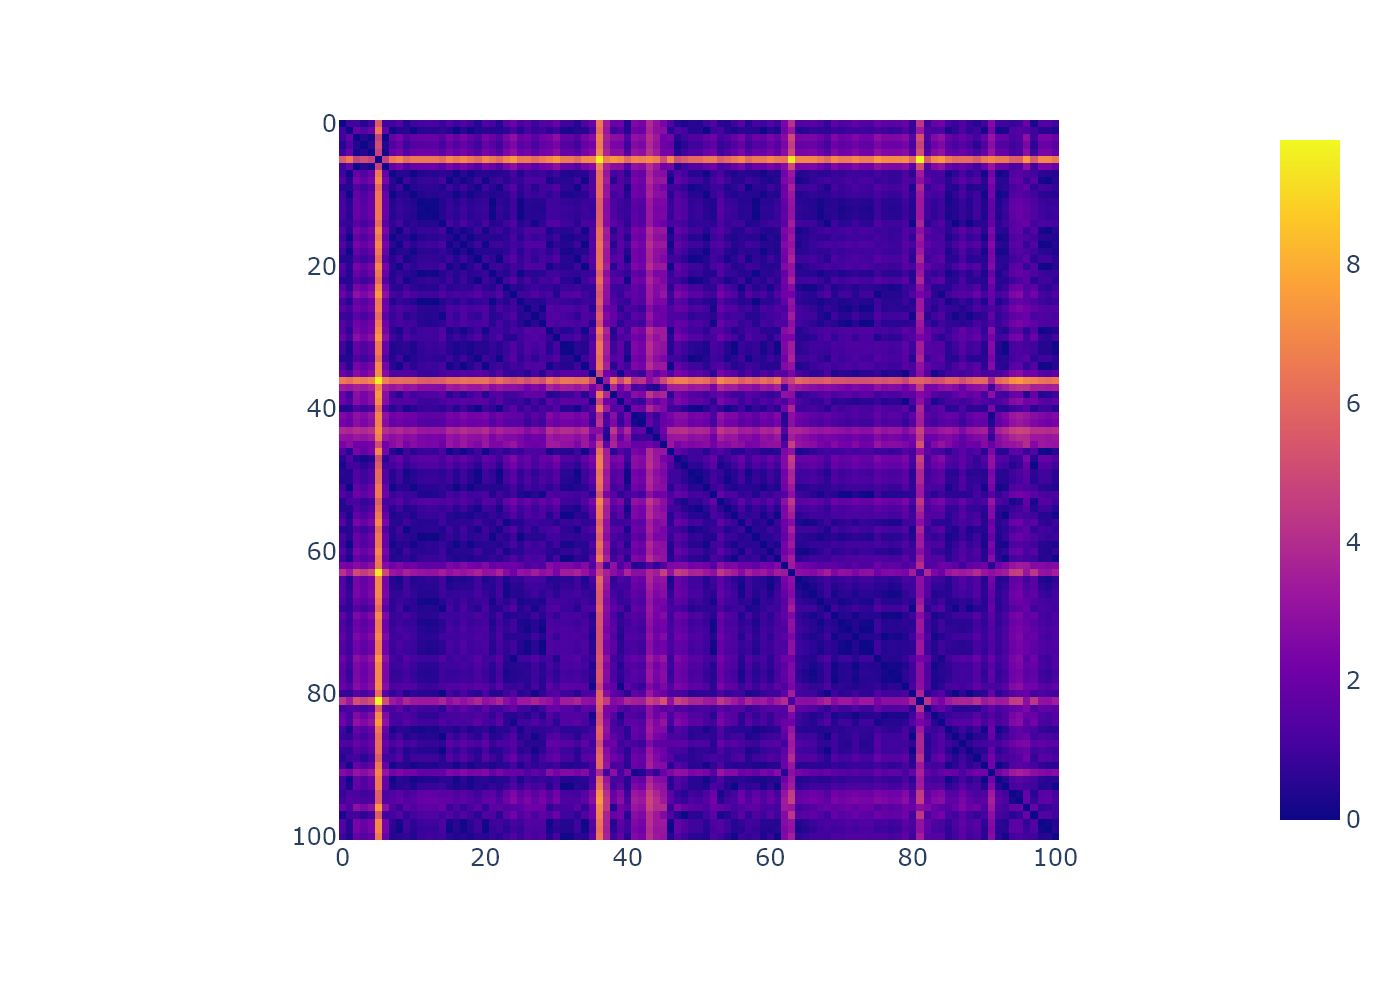

In [21]:
show_figure(px.imshow(train_distance_matrix))